In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st
import seaborn as sns
import networkx as nx
import pandas as pd

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot, column

from mpl_toolkits.mplot3d import Axes3D

# pip install ndlib
# pip install networkx==3.3
# pip install ndlib==5.1.0
# pip install bokeh==2.3.3

AttributeError: module 'numpy' has no attribute 'bool8'

# Implement Gillespie's algorithm

Gillespie's Algorithm (Stochastic SIR Model)

In [2]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0

In [ ]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    R0_stoch = beta / (mu + gamma)

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If there are no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Rates for all possible events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # If rate_sum is zero, no more events are possible
        if rate_sum <= 0:
            break  # End the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # Determine which event happens next
        if rand < (cum_rate := cum_rate + birth_rate): # Birth
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # Infection
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # Recovery
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # Death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # Death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # Death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)

    return X, Y, Z, t, R0_stoch

tend = 200 # simulation time (200 days)
seed = 42

Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

Deterministic SIR Model

In [ ]:
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

# Defining the deterministic ODEs
def SIR(val, t, beta, gamma, mu, N): 
    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])

# Solving the deterministic SIR model
def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    R0_det = beta / (mu + gamma)

    time = np.linspace(start_t, end_t, points_t)
    init_val = [X0, Y0, Z0]
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu, N))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time, R0_det

Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()
plt.show()


Plotting Deterministic and Stochastic SIR

In [ ]:
# Solving the deterministic model
Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
# Solving the stochastic model using Gillespie algorithm
Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(time, Xd, label="Susceptible", color='blue')
ax1.plot(time, Yd, label="Infected", color='red')
ax1.plot(time, Zd, label="Recovered", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

ax2.plot(t, Xs, label="Susceptible", color='blue')
ax2.plot(t, Ys, label="Infected", color='red')
ax2.plot(t, Zs, label="Recovered", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()
plt.show()

Function to run multiple simulations of stochastic SIR (and return mean and variance of X, Y, Z)

In [ ]:
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed):
    # Accumulating Xs, Ys, Zs across simulations
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []
    cov_array = np.zeros(tend)

    time_p = np.linspace(0, tend, 200) # 200 time points

    for i in range(sims):
        # Run Gillespie simulation for current iteration
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # Interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    # Average population size of each compartment at each time point
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # Variability of population sizes across simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    return time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys

# Computing covariance between S and I
def covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend):
    cov_Xs_Ys = np.zeros(tend)
    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    return cov_Xs_Ys

sims = 50
X0 = 999
Y0 = 1
Z0 = 0
beta = 1
gamma = 1/30
mu = 1/60
N = X0 + Y0 + Z0
tend = 200

# Run the stochastic simulations
time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend)

print(f"Number of simulations: {sims}")
print(f"Mean of Susceptibles: {mean_Xs[-1]}")
print(f"Variance of Susceptibles: {var_Xs[-1]}")
print(f"Mean of Infected: {mean_Ys[-1]}")
print(f"Variance of Infected: {var_Ys[-1]}")

# Plotting the mean, variance and covariance (X vs Y)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

std_Xs = np.std(all_Xs, axis=0)
std_Ys = np.std(all_Ys, axis=0)

axes[0].plot(time_p, mean_Xs, label='Mean Susceptible', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected', color='red')
axes[0].fill_between(time_p, mean_Xs - std_Xs, mean_Xs + std_Xs, color='blue', alpha=0.2)
axes[0].fill_between(time_p, mean_Ys - std_Ys, mean_Ys + std_Ys, color='red', alpha=0.2)
axes[0].set_title("Mean Dynamics")
axes[0].set_xlabel("Time (Days)")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_p, var_Xs, label='Variance Susceptible', color='blue')
axes[1].plot(time_p, var_Ys, label='Variance Infected', color='red')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time (Days)")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Covariance (X vs Y)', color='blue')
axes[2].set_title("Covariance Dynamics (X vs Y)")
axes[2].set_xlabel("Time (Days)")
axes[2].set_ylabel("Covariance")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Investigate Simulation Variability and Negative Co-variance

In [42]:
# Fixed parameters
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 5

Varying N

In [ ]:

def diff_params_N(N_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # Means from the deterministic model
    mean_stoch = []  # Means from the stochastic model
    var_Y = []       # Variances of Y
    cov_XY = []      # Covariances between X and Y
    correlations = []  # Correlations between X and Y

    # Iterate through different population sizes
    for n in np.nditer(N_diff):
        X0 = int(n) - 1   # Initial susceptible population
        Y0 = 1            # Initial infected population
        Z0 = 0            # Initial recovered population
        
        # Run stochastic and deterministic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, int(n), tend=200)
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, int(n), beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append final mean for deterministic and stochastic model
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys))

        # Append final variance of stochastic model
        var_Y.append(np.mean(var_Ys)) 

        # Calculate and append final covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

        # Calculate the correlation between X and Y
        correlation_si = np.corrcoef(all_Xs.flatten(), all_Ys.flatten())[0, 1]  # Correlation coefficient between S and I
        correlations.append(correlation_si)
        
    # Reduce the number of population sizes shown in the heatmap
    selected_indices = np.linspace(0, len(N_diff) - 1, 20).astype(int)  # Select 20 population sizes to display
    N_diff_selected = N_diff[selected_indices]
    correlations_selected = np.array(correlations)[selected_indices]

    # Create a heatmap of the correlation between X and Y across population sizes
    plt.figure(figsize=(12, 4))
    sns.heatmap(np.array(correlations_selected).reshape(1, -1), annot=True, cmap='coolwarm', xticklabels=np.round(N_diff_selected).astype(int))
    plt.title("Correlation between S and I across Population Sizes")
    plt.xlabel("Population Size (N)")
    plt.ylabel("Correlation (S vs I)")
    plt.show()

    # Initialize the other plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different N")
    axes[0].set_xlabel("Population Size (N)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(N_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over N
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Population Size (N)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(N_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over N
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Population Size (N)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY , time_p, all_Ys

# Example usage
N_diff = np.linspace(2, 10000, 100)  # Different values of population
sims = 20  # Number of stochastic simulations
beta = 1.5
gamma = 0.5
mu = 0.01

diff_params_N(N_diff, sims, beta, gamma, mu)


Varying Y0 (initial number of infectious individuals)

In [ ]:
Y0_diff = np.linspace(1, 1000, 50)

def diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different initial infected populations Y0
    for y0 in Y0_diff:
        X0 = N - y0  # Initial susceptible population
        Y0 = y0      # Initial infected population
        Z0 = 0       # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(Y0_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(Y0_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Initial Infected (Y0)")
    axes[0].set_xlabel("Initial Infected Population (Y0)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(Y0_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over Y0
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Initial Infected Population (Y0)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(Y0_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over Y0
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Initial Infected Population (Y0)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 20


diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu)


Varying beta (transmission rate)

In [ ]:
beta_diff = np.linspace(0, 10, 20)

def diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different beta values
    for beta in beta_diff:
        
        # Run stochastic simulations for the current beta
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current beta
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(beta_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(beta_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Beta Values")
    axes[0].set_xlabel("Transmission Rate (Beta)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(beta_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over beta
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Transmission Rate (Beta)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(beta_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over beta
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Transmission Rate (Beta)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

N = 1000
gamma = 1/3
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
sims = 20

# Call the function with fixed parameters and varying beta
diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0)

Varying gamma (rate of recovery)

In [ ]:
gamma_diff = np.linspace(0.01, 1, 50)


def diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different gamma values
    for gamma in gamma_diff:

        # Run stochastic simulations for the current gamma
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current gamma
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(gamma_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(gamma_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Gamma Values")
    axes[0].set_xlabel("Recovery Rate (Gamma)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(gamma_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over gamma
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Recovery Rate (Gamma)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(gamma_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over gamma
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Recovery Rate (Gamma)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

N = 1000
beta = 1
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
sims = 20

# Call the function with fixed parameters and varying gamma
diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0)

Varying mu (birth rate)

In [ ]:
mu_diff = np.linspace(0.01, 0.5, 20)

def diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different mu values
    for mu in mu_diff:
        # Run stochastic simulations for the current mu
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current mu
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(mu_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(mu_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Mu Values")
    axes[0].set_xlabel("Natural Death Rate (Mu)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(mu_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over mu
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Natural Death Rate (Mu)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(mu_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over mu
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Natural Death Rate (Mu)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

N = 1000
beta = 1
gamma = 1/3
X0 = 999
Y0 = 1
Z0 = 0
sims = 20

# Call the function with varying mu
diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0)

# Stochastic Resonance and Increased Transient

In [ ]:
N = [50, 200, 500, 1000]
beta = 1
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, n in enumerate(N):
    X0 = n - 1
    Y0 = 1
    Z0 = 0

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, n, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, n, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (N={n})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


In [ ]:
beta_values = [1 / 5, 1 / 2, 1, 2]  # Different values for beta
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000
N = 1000
X0 = 999
Y0 = 1
Z0 = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, beta in enumerate(beta_values):

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (β={beta})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()

In [ ]:
gamma_values = [1 / 10, 1 / 5, 1 / 2, 0.8 ]  # Different values for gamma
N = 1000 
beta = 0.5
mu = 1 / 30
start_t = 0
end_t = 500
points_t = 500
sims = 20
tend = 500
X0 = 999
Y0 = 1
Z0 = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i, gamma in enumerate(gamma_values):

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (γ={gamma})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


# Extinction event (different R0, fixed population size N)

In [ ]:
sims_ext = 10

X0 = 999
Y0 = 1
Z0 = 0

N = 1000 

# R0 = beta / (gamma + mu)

beta_ext = np.linspace(0, 15, sims_ext)
gamma_ext = np.linspace(0.01, 10, sims_ext)
mu_ext = np.linspace(0.01, 3, sims_ext)

R0_ext = beta_ext / (gamma_ext + mu_ext)

Yd_ext = []
Ys_ext = []
extinction_stoch = []  # To track whether extinction happened in stochastic runs
extinction_deter = []  # To track extinction in deterministic runs

for i in range(sims_ext):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta_ext[i], gamma_ext[i], mu_ext[i], start_t = 0, end_t = 200, points_t = 200)
    Yd_ext.append(Yd[-1])
    extinction_deter.append(1 if Yd[-1] == 0 else 0)

    Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], N, tend = 200, seed = i)
    Ys_ext.append(Ys[-1])
    extinction_stoch.append(1 if Ys[-1] == 0 else 0)

print("Stochastic extinctions:", np.sum(extinction_stoch), "out of " f"{sims_ext}" " simulations.")
print("Deterministic extinctions:", np.sum(extinction_deter),"out of " f"{sims_ext}" " simulations.")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation_and_plot(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    - param_diff: Array of different values of N or R0.
    - param_name: Name of the parameter being varied ("N" or "R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions
        
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)
            else:
                X0 = X0  # Keep it fixed for R0

            # Run the simulation using gillespie_sir for current beta, gamma, mu
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs
            else:
                # If no extinction occurs, do nothing
                pass

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted


# Example parameters
sims_ext = 10  # Number of simulations per parameter
beta_ext = np.logspace(-1, 1.5, sims_ext)  # Transmission rates in the range [0.1, 31.6]
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 365  # Simulation end time

# N and R0 values
N_diff = np.linspace(500, 10000, 10)  # Population sizes for which we will run simulations
R0_diff = beta_ext / (gamma_ext + mu_ext)  # Calculate R0 values
X0 = 999  # Initial number of susceptible individuals
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

# Run the simulations for N and R0
N_sorted, Ys_ext2_N_sorted, extinction_counts_N_sorted = run_simulation_and_plot(N_diff, "N", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)
R0_sorted, Ys_ext2_R0_sorted, extinction_counts_R0_sorted = run_simulation_and_plot(R0_diff, "R0", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)

# Create 2x2 subplot for all four plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Average extinction time vs N
ax[0, 0].plot(N_sorted, Ys_ext2_N_sorted, marker='o', color='blue', label='Avg Extinction Time (N)')
ax[0, 0].set_title("Average Extinction Time vs Population Size (N)")
ax[0, 0].set_xlabel("Population size N")
ax[0, 0].set_ylabel("Average Time to Extinction")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs N
ax[0, 1].plot(N_sorted, extinction_counts_N_sorted, marker='o', color='green', label='Number of Extinctions (N)')
ax[0, 1].set_title("Total Number of Extinctions vs Population Size (N)")
ax[0, 1].set_xlabel("Population size N")
ax[0, 1].set_ylabel("Total Number of Extinctions")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 3: Average extinction time vs R0
ax[1, 0].plot(R0_sorted, Ys_ext2_R0_sorted, marker='o', color='blue', label='Avg Extinction Time (R0)')
ax[1, 0].set_title("Average Extinction Time vs R0")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Average Time to Extinction")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 4: Total number of extinctions vs R0
ax[1, 1].plot(R0_sorted, extinction_counts_R0_sorted, marker='o', color='green', label='Number of Extinctions (R0)')
ax[1, 1].set_title("Total Number of Extinctions vs R0")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calc_ext_prob(R0):
    """Calculate the extinction probability given R0, and ensure it's clipped to the [0, 1] range."""
    return np.clip(1 / R0, 0, 1)

def run_simulation_and_plotN(param_diff, param_name, sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0, vary_params=False):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    - param_diff: Array of different values of N or R0.
    - param_name: Name of the parameter being varied ("N" or "R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_const, gamma_const, mu_const: Constant transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    - vary_params: If True, vary beta, gamma, and mu for each N.
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value
    probabilities = []  # Extinction probabilities for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions

        # Vary parameters if necessary
        if vary_params:
            beta = np.random.uniform(0.1, 4)  # Vary beta randomly
            gamma = np.random.uniform(0.01, 1)   # Vary gamma randomly
            mu = np.random.uniform(0.01, 0.5)   # Vary mu randomly
            R0 = beta / (gamma + mu)  # Calculate new R0 for each N when varying parameters
        else:
            beta, gamma, mu = beta_const, gamma_const, mu_const  # Keep beta, gamma, mu constant
            R0 = beta / (gamma + mu)  # Fixed R0 based on constant parameters

        # Clip R0 if it's too small to avoid probabilities > 1
        if R0 < 1:
            R0 = 1.01  # Ensure R0 stays slightly above 1

        # Loop over simulations
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)

            # Run the simulation using the gillespie_sir function (assuming it exists in your environment)
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        # Append results for this parameter value
        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        probabilities.append(calc_ext_prob(R0))  # Store the calculated probability for this parameter

        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}, extinction probability = {probabilities[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted, probabilities_sorted


# Example parameters
sims_ext = 30  # Number of simulations per parameter
beta_const = 1  # Fixed transmission rate for N plots
gamma_const = 1/3  # Fixed recovery rate for N plots
mu_const = 1/60  # Fixed death rate for N plots
t_end = 365  # Simulation end time

# N values for varying N
N_diff = np.linspace(1000, 10000, 10)  # Population sizes for which we will run simulations
X0 = 999  # Initial number of susceptible individuals
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

# ------------------ First set of plots: N with constant beta, gamma, and mu ------------------
N_sorted_const, Ys_ext2_N_const_sorted, extinction_counts_N_const_sorted, probabilities_N_const_sorted = run_simulation_and_plotN(N_diff, "N", sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0)

# ------------------ Second set of plots: N with varying beta, gamma, and mu ------------------
N_sorted_vary, Ys_ext2_N_vary_sorted, extinction_counts_N_vary_sorted, probabilities_N_vary_sorted = run_simulation_and_plotN(N_diff, "N", sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0, vary_params=True)

# Create 3x2 subplot for all six plots
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

# ------------------ First Row: Constant Parameters ------------------
# Plot 1: Extinction probability vs N (constant parameters)
ax[0, 0].plot(N_sorted_const, probabilities_N_const_sorted, marker='o', color='red', label='Extinction Probability (N, constant params)')
ax[0, 0].set_title("Extinction Probability vs N (constant params)")
ax[0, 0].set_xlabel("Population Size (N)")
ax[0, 0].set_ylabel("Extinction Probability")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs N (constant parameters)
ax[1, 0].plot(N_sorted_const, extinction_counts_N_const_sorted, marker='o', color='green', label='Number of Extinctions (N, constant params)')
ax[1, 0].set_title("Total Number of Extinctions vs N (constant params)")
ax[1, 0].set_xlabel("Population Size (N)")
ax[1, 0].set_ylabel("Total Number of Extinctions")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 3: Average extinction time vs N (constant parameters)
ax[2, 0].plot(N_sorted_const, Ys_ext2_N_const_sorted, marker='o', color='blue', label='Avg Extinction Time (N, constant params)')
ax[2, 0].set_title("Average Extinction Time vs N (constant params)")
ax[2, 0].set_xlabel("Population Size (N)")
ax[2, 0].set_ylabel("Average Time to Extinction")
ax[2, 0].grid(True)
ax[2, 0].legend()

# ------------------ Second Row: Varying Parameters ------------------
# Plot 4: Extinction probability vs N (varying parameters)
ax[0, 1].plot(N_sorted_vary, probabilities_N_vary_sorted, marker='o', color='red', label='Extinction Probability (N, varying params)')
ax[0, 1].set_title("Extinction Probability vs N (varying params)")
ax[0, 1].set_xlabel("Population Size (N)")
ax[0, 1].set_ylabel("Extinction Probability")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 5: Total number of extinctions vs N (varying parameters)
ax[1, 1].plot(N_sorted_vary, extinction_counts_N_vary_sorted, marker='o', color='green', label='Number of Extinctions (N, varying params)')
ax[1, 1].set_title("Total Number of Extinctions vs N (varying params)")
ax[1, 1].set_xlabel("Population Size (N)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

# Plot 6: Average extinction time vs N (varying parameters)
ax[2, 1].plot(N_sorted_vary, Ys_ext2_N_vary_sorted, marker='o', color='blue', label='Avg Extinction Time (N, varying params)')
ax[2, 1].set_title("Average Extinction Time vs N (varying params)")
ax[2, 1].set_xlabel("Population Size (N)")
ax[2, 1].set_ylabel("Average Time to Extinction")
ax[2, 1].grid(True)
ax[2, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calc_ext_prob(R0):
    """Calculate the extinction probability given R0 (with i=1 initial infection)."""
    return 1 / R0

def run_simulation_and_plot_r0(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics for varying R0.
    
    Args:
    - param_diff: Array of different values of R0.
    - param_name: Name of the parameter being varied ("R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value
    probabilities = []  # Extinction probabilities for each parameter value

    # Loop over different values of R0
    for i, R0 in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions

        beta = R0 * (gamma_ext[i % len(gamma_ext)] + mu_ext[i % len(mu_ext)])  # Calculate beta for given R0
        gamma = gamma_ext[i % len(gamma_ext)]  # Recovery rate
        mu = mu_ext[i % len(mu_ext)]  # Death rate

        # Loop over simulations
        for sim in range(sims_ext):
            # Run the simulation using the gillespie_sir function (assuming it exists in your environment)
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        # Append results for this parameter value
        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        probabilities.append(calc_ext_prob(R0))  # Store the calculated probability for this parameter

        print(f'For {param_name} = {R0}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}, extinction probability = {probabilities[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted, probabilities_sorted


# Example parameters
sims_ext = 10  # Number of simulations per parameter
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 365  # Simulation end time

# R0 values for varying R0
R0_diff = np.linspace(1.1, 5, 10)  # Vary R0 values directly

# ------------------ First set of plots: R0 with N = 2000 ------------------
X0_2000 = 2000 - 1  # Susceptible individuals for N = 2000
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

R0_sorted_2000, Ys_ext2_R0_sorted_2000, extinction_counts_R0_sorted_2000, probabilities_R0_sorted_2000 = run_simulation_and_plot_r0(
    R0_diff, "R0", sims_ext, None, gamma_ext, mu_ext, t_end, X0_2000, Y0, Z0)

# ------------------ Second set of plots: R0 with N = 10000 ------------------
X0_10000 = 10000 - 1  # Susceptible individuals for N = 10000

R0_sorted_10000, Ys_ext2_R0_sorted_10000, extinction_counts_R0_sorted_10000, probabilities_R0_sorted_10000 = run_simulation_and_plot_r0(
    R0_diff, "R0", sims_ext, None, gamma_ext, mu_ext, t_end, X0_10000, Y0, Z0)

# Create 3x2 subplot for all six plots
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

# ------------------ First Row: N = 2000 ------------------
# Plot 1: Extinction probability vs R0 (N = 2000)
ax[0, 0].plot(R0_sorted_2000, probabilities_R0_sorted_2000, marker='o', color='red', label='Extinction Probability (R0, N=2000)')
ax[0, 0].set_title("Extinction Probability vs R0 (N=2000)")
ax[0, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[0, 0].set_ylabel("Extinction Probability")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs R0 (N = 2000)
ax[1, 0].plot(R0_sorted_2000, extinction_counts_R0_sorted_2000, marker='o', color='green', label='Number of Extinctions (R0, N=2000)')
ax[1, 0].set_title("Total Number of Extinctions vs R0 (N=2000)")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Total Number of Extinctions")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 3: Average extinction time vs R0 (N = 2000)
ax[2, 0].plot(R0_sorted_2000, Ys_ext2_R0_sorted_2000, marker='o', color='blue', label='Avg Extinction Time (R0, N=2000)')
ax[2, 0].set_title("Average Extinction Time vs R0 (N=2000)")
ax[2, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[2, 0].set_ylabel("Average Time to Extinction")
ax[2, 0].grid(True)
ax[2, 0].legend()

# ------------------ Second Row: N = 10000 ------------------
# Plot 4: Extinction probability vs R0 (N = 10000)
ax[0, 1].plot(R0_sorted_10000, probabilities_R0_sorted_10000, marker='o', color='red', label='Extinction Probability (R0, N=10000)')
ax[0, 1].set_title("Extinction Probability vs R0 (N=10000)")
ax[0, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[0, 1].set_ylabel("Extinction Probability")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 5: Total number of extinctions vs R0 (N = 10000)
ax[1, 1].plot(R0_sorted_10000, extinction_counts_R0_sorted_10000, marker='o', color='green', label='Number of Extinctions (R0, N=10000)')
ax[1, 1].set_title("Total Number of Extinctions vs R0 (N=10000)")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

# Plot 6: Average extinction time vs R0 (N = 10000)
ax[2, 1].plot(R0_sorted_10000, Ys_ext2_R0_sorted_10000, marker='o', color='blue', label='Avg Extinction Time (R0, N=10000)')
ax[2, 1].set_title("Average Extinction Time vs R0 (N=10000)")
ax[2, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[2, 1].set_ylabel("Average Time to Extinction")
ax[2, 1].grid(True)
ax[2, 1].legend()

plt.tight_layout()
plt.show()


# Problem 2


#### 2.1 Implement SIR and Simulate

In [ ]:
output_notebook()

# Function to generate networks
def generate_networks(nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb):
    erdos = nx.erdos_renyi_graph(nodes, edge_prob_erdos)
    watts = nx.watts_strogatz_graph(nodes, k_connections_watts, edge_prob_watts)
    barabasi = nx.barabasi_albert_graph(nodes, nr_edges_barb)
    return [erdos, watts, barabasi]

# Function to run SIR model on a given network
def run_sir_model(network, beta, gamma, fraction_infected, num_iterations = 50):
    model = ep.SIRModel(network)
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter('fraction_infected', fraction_infected)
    model.set_initial_status(cfg)

    simulations = model.iteration_bunch(num_iterations)
    
    iterations = [sim['iteration'] for sim in simulations]
    susceptible = [sim['node_count'][0] for sim in simulations]
    infected = [sim['node_count'][1] for sim in simulations]
    recovered = [sim['node_count'][2] for sim in simulations]
    
    return iterations, susceptible, infected, recovered

def plot_results(networks, results, titles):
    plots = []
    prevalence_plots = []
    for idx, (iterations, susceptible, infected_counts, recovered) in enumerate(results):

        p = figure(title=titles[idx], x_axis_label='Iterations', y_axis_label='Number of Individuals', width=400, height=400)
        
        p.line(iterations, susceptible, legend_label='Susceptible', color='blue', line_width=2)
        p.line(iterations, infected_counts, legend_label='Infected', color='red', line_width=2)
        p.line(iterations, recovered, legend_label='Recovered', color='green', line_width=2)
        
        p.legend.title = "States"
        p.legend.location = "top_right"
        
        plots.append(p)

        # Compute prevalence of Infectious individuals
        total_population = susceptible[0] + infected_counts[0] + recovered[0]
        prevalence = [i / total_population for i in infected_counts]

        prevalence_plot = figure(title=f"{titles[idx]} - Prevalence", x_axis_label='Iterations', y_axis_label='Proportion Infected',
                                 width=400, height=400)

        prevalence_plot.line(iterations, prevalence, legend_label='Prevalence', color='purple', line_width=2)
        prevalence_plot.legend.location = "top_right"
        
        prevalence_plots.append(prevalence_plot)

    grid = gridplot([[plots[0], plots[1], plots[2]], [prevalence_plots[0], prevalence_plots[1], prevalence_plots[2]]])
    show(grid)

# Function to run multiple simulations across networks
def run_networks(beta, gamma, fraction_infected, nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb, repetitions, num_iterations = 50, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    networks = generate_networks(nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb)
    titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
    results = []
    
    # Repeat the simulation across each network for the given number of repetitions
    for network in networks:
        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            iterations, susceptible, infected, recovered = run_sir_model(network, beta, gamma, fraction_infected)
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    plot_results(networks, results, titles)

In [ ]:
run_networks(beta=1, gamma = 1/3, fraction_infected=0.02, nodes=1000, edge_prob_erdos=0.1, edge_prob_watts=0.1, k_connections_watts=4, nr_edges_barb=2, repetitions=40, seed=42)

#### 2.2 Generate Networks of equivalent form

In [4]:
# Function to generate and plot network models, degree distributions, and centralities
def generate_and_plot_networks_with_centralities(nodes, k, p_watts, m_barabasi, p_erdos, seed=None):
    # Set seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)  # Seed numpy as well for further consistency
    
    # Generate the networks
    watts = nx.watts_strogatz_graph(nodes, k, p_watts, seed=seed)
    barabasi = nx.barabasi_albert_graph(nodes, m_barabasi, seed=seed)
    erdos = nx.erdos_renyi_graph(nodes, p_erdos, seed=seed)

    # Plot the networks
    plt.figure(figsize=(18, 6))
    
    # Watts-Strogatz
    plt.subplot(1, 3, 1)
    nx.draw(watts, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Watts-Strogatz ($k={k}, p={p_watts}$)')

    # Barabási-Albert
    plt.subplot(1, 3, 2)
    nx.draw(barabasi, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Barabási-Albert ($m={m_barabasi}$)')

    # Erdős-Rényi
    plt.subplot(1, 3, 3)
    nx.draw(erdos, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Erdős-Rényi ($p={p_erdos}$)')
    
    plt.tight_layout()
    plt.show()

    # Plot the degree distributions
    plt.figure(figsize=(18, 6))
    
    # Watts-Strogatz Degree Distribution
    plt.subplot(1, 3, 1)
    watts_degrees = [d for n, d in watts.degree()]
    sns.histplot(watts_degrees, bins=10)
    plt.title(f'Watts-Strogatz Degree Distribution\n$k={k}, p={p_watts}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    # Barabási-Albert Degree Distribution
    plt.subplot(1, 3, 2)
    barabasi_degrees = [d for n, d in barabasi.degree()]
    sns.histplot(barabasi_degrees, bins=10)
    plt.title(f'Barabási-Albert Degree Distribution\n$m={m_barabasi}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    # Erdős-Rényi Degree Distribution
    plt.subplot(1, 3, 3)
    erdos_degrees = [d for n, d in erdos.degree()]
    sns.histplot(erdos_degrees, bins=10)
    plt.title(f'Erdős-Rényi Degree Distribution\n$p={p_erdos}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    
    plt.tight_layout()
    plt.show()

    # Centrality measures and plots for each network
    for net, name in zip([watts, barabasi, erdos], ['Watts-Strogatz', 'Barabási-Albert', 'Erdős-Rényi']):
        plt.figure(figsize=(18, 6))
        
        # Degree Centrality
        degree_centrality = nx.degree_centrality(net)
        degree_values = list(degree_centrality.values())
        plt.subplot(1, 3, 1)
        sns.histplot(degree_values, bins=10)
        plt.axvline(x=np.mean(degree_values), color='red', linestyle='--', label='Mean Degree Centrality')
        plt.title(f'{name} Degree Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()

        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(net)
        betweenness_values = list(betweenness_centrality.values())
        plt.subplot(1, 3, 2)
        sns.histplot(betweenness_values, bins=10)
        plt.axvline(x=np.mean(betweenness_values), color='red', linestyle='--', label='Mean Betweenness Centrality')
        plt.title(f'{name} Betweenness Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()

        # Closeness Centrality
        closeness_centrality = nx.closeness_centrality(net)
        closeness_values = list(closeness_centrality.values())
        plt.subplot(1, 3, 3)
        sns.histplot(closeness_values, bins=10)
        plt.axvline(x=np.mean(closeness_values), color='red', linestyle='--', label='Mean Closeness Centrality')
        plt.title(f'{name} Closeness Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    return watts, barabasi, erdos  # Return the networks for future use


In [ ]:
watts1, barabasi1, erdos1 = generate_and_plot_networks_with_centralities(nodes=100, k=6, p_watts=0.1, m_barabasi=3, p_erdos=0.06, seed=42)

In [ ]:
watts2, barabasi2, erdos2 = generate_and_plot_networks_with_centralities(nodes=500, k=5, p_watts=0.2, m_barabasi=2, p_erdos=0.05, seed=42)

In [ ]:
watts3, barabasi3, erdos3 = generate_and_plot_networks_with_centralities(nodes=1000, k=7, p_watts=0.15, m_barabasi=4, p_erdos=0.07, seed=42)

#### 2.3 Simulate SIR spread on the network

In [ ]:
# Function to run multiple simulations across networks and varying parameters
def run_networks(networks, titles, beta, gamma, fraction_infected, repetitions, num_iterations=50, seed=None):
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    results = []
    infected_nodes_lists = []  # Initialize list to store initial infected nodes for each network
    
    # Repeat the simulation across each network for the given number of repetitions
    for index, network in enumerate(networks):
        # Create the model
        model = ep.SIRModel(network)

        # Create the configuration and add parameters
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        cfg.add_model_parameter('fraction_infected', fraction_infected)
        model.set_initial_status(cfg)

        # Get initial infected nodes
        initial_infected_nodes = [node for node in network.nodes() if model.status[node] == 1]
        infected_nodes_lists.append(initial_infected_nodes)  # Store in the infected_nodes_lists

        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            iterations, susceptible, infected, recovered = run_sir_model(network, beta, gamma, fraction_infected)
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        # Averaging over repetitions
        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    plot_results(networks, results, titles)
    
    return infected_nodes_lists  # Return the list of initial infected nodes for each network

# Example usage
# Assuming networks is a list of your three network structures
# networks = [watts2, barabasi2, erdos2]
# titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
# infected_nodes_lists = run_networks(networks, titles, beta=1, gamma=0.05, fraction_infected=0.02, repetitions=20)

# Print the initial infected nodes for verification
# print(infected_nodes_lists)


# Example usage
# Assuming networks is a list of your three network structures
networks = [watts2, barabasi2, erdos2]
titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
infected_nodes_lists = run_networks(networks, titles, beta=1, gamma=0.05, fraction_infected=0.02, repetitions=20)




In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Function to plot the initial conditions of multiple networks side by side
def plot_initial_conditions_3d(networks, infected_nodes_lists, titles):
    fig = plt.figure(figsize=(16, 5))

    for i, (network, infected_nodes) in enumerate(zip(networks, infected_nodes_lists)):
        # Get a 3D layout for the network
        pos = nx.spring_layout(network, dim=3, seed=42)  # Seed for consistent layout

        # Create a 3D subplot
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.set_title(titles[i])
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        # Prepare node positions for 3D plotting
        node_xyz = np.array([pos[v] for v in sorted(network)])
        x_vals, y_vals, z_vals = node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2]

        # Define node colors based on their state at t=0
        node_colors = ['red' if node in infected_nodes else 'blue' for node in network.nodes()]

        # Plot nodes
        ax.scatter(x_vals, y_vals, z_vals, c=node_colors, s=100, edgecolor='k', alpha=0.8)

        # Plot edges
        for i, j in network.edges():
            x = np.array((pos[i][0], pos[j][0]))
            y = np.array((pos[i][1], pos[j][1]))
            z = np.array((pos[i][2], pos[j][2]))
            ax.plot(x, y, z, color='black', alpha=0.5)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Example usage with existing networks and infected nodes
def plot_all_networks_with_infected_nodes(networks, infected_nodes_lists):
    titles = ['Erdos-Renyi Network at t=0', 'Watts-Strogatz Network at t=0', 'Barabasi-Albert Network at t=0']
    
    # Call the plotting function
    plot_initial_conditions_3d(networks, infected_nodes_lists, titles)

# Assuming `networks` is a list of the three pre-defined network structures and
# `infected_nodes_lists` is a list containing the lists of infected nodes for each network
# Example:
# networks = [erdos_network, watts_network, barabasi_network]
# infected_nodes_lists = [infected_nodes_erdos, infected_nodes_watts, infected_nodes_barabasi]
# plot_all_networks_with_infected_nodes(networks, infected_nodes_lists)


In [9]:
networks = [watts2, barabasi2, erdos2]
titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
beta = 1
gamma = 1/6

In [ ]:
infected_nodes_lists = run_networks(networks, titles, beta, gamma, repetitions=20, num_iterations=50, fraction_infected=0.01, seed=None)
plot_all_networks_with_infected_nodes(networks, infected_nodes_lists)

In [15]:
import numpy as np
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

def run_sir_model_with_degree(network, beta, gamma, degree_k, num_iterations=50):
    # Create a new SIR model instance
    model = ep.SIRModel(network)
    cfg = mc.Configuration()
    
    # Set model parameters
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)

    # Get nodes with the specific degree k
    infected_nodes = [node for node in network.nodes if network.degree(node) == degree_k]

    # Create an initial status dictionary
    initial_status = {node: 0 for node in network.nodes}  # Set all to susceptible
    for node in infected_nodes:
        initial_status[node] = 1  # Set infected

    # Set the initial status in the model
    model.set_initial_status(initial_status)

    # Run the simulation
    model.set_initial_status(initial_status)
    iterations = model.iteration_bunch(num_iterations)

    # Extract data for plotting
    iters = [sim['iteration'] for sim in iterations]
    susceptible = [sim['node_count'][0] for sim in iterations]
    infected_counts = [sim['node_count'][1] for sim in iterations]
    recovered = [sim['node_count'][2] for sim in iterations]

    return iters, susceptible, infected_counts, recovered


def run_networks_with_degree(networks, beta, gamma, degree_k, repetitions, num_iterations=50, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    results = []
    
    for network in networks:
        # Initialize arrays to hold counts for averaging
        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            # Run the SIR model for the current network with the specified degree k
            iterations, susceptible, infected, recovered = run_sir_model_with_degree(network, beta, gamma, degree_k, num_iterations)

            # Accumulate results
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        # Average over repetitions
        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        # Append results for the current network
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    return results


In [ ]:
run_networks_with_degree(networks, 1, 1/6, 1, 50, 50, seed = None)


#### 2.4 Dynamic Vaccination Campaign

In [37]:
# Step 1: Load the transmission network
df = pd.read_csv('transmission_network.csv', index_col=0, delimiter=';')
df = df.map(lambda x: 1 if x != 0 else x)
G = nx.from_numpy_array(df.values)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 374
Number of edges: 1265


In [312]:
# Step 2: Randomly select 5 initial infected nodes with a seed for reproducibility
def select_initial_infected(G, num_initial_infected, seed=None):
    """Randomly selects a number of nodes to be initially infected from the network G."""
    if seed is not None:
        random.seed(seed)
    initial_infected = random.sample(list(G.nodes), num_initial_infected)
    print(f"Selected {num_initial_infected} initial infected nodes: {initial_infected}")
    return initial_infected
initial_infected = select_initial_infected(G, 5, seed=42)


Selected 5 initial infected nodes: [327, 57, 12, 140, 125]


In [313]:
# Dynamic testing function
def dynamic_testing(G, model_status, test_accuracy, max_tests_per_iteration, vaccinated_nodes, positive_tested_nodes, time_step):
    """
    Dynamic testing strategy.
    """
    tested_positive = []
    tested_negative = []
    tested_this_round = set()  # Track tested nodes for the current iteration
    remaining_tests = max_tests_per_iteration

    # Re-test positive nodes every 3 days
    for node, last_positive_day in list(positive_tested_nodes.items()):
        if node in vaccinated_nodes or node in tested_this_round:
            continue
        if (time_step - last_positive_day) >= 3:
            if model_status[node] == 1:
                if random.uniform(0,1) <= test_accuracy:
                    tested_positive.append(node)
                    positive_tested_nodes[node] = time_step
                else:
                    tested_negative.append(node)
                    del positive_tested_nodes[node]
            else:
                tested_negative.append(node)
                del positive_tested_nodes[node]
            tested_this_round.add(node)
            remaining_tests -= 1
            if remaining_tests <= 0:
                return tested_positive, tested_negative

    # Test nodes by degree
    nodes_by_degree = sorted([n for n in G.nodes() if n not in vaccinated_nodes and n not in positive_tested_nodes and n not in tested_this_round],
                             key=lambda x: G.degree[x], reverse=True)
    
    i = 0
    while remaining_tests > 0 and i < len(nodes_by_degree):
        to_test = nodes_by_degree[i:i + 5]
        i += 5

        infected_found = False
        local_positive = []
        local_negative = []

        for node in to_test:
            if remaining_tests <= 0:
                break

            if node not in tested_this_round:  # Ensure node isn't tested twice
                if model_status[node] == 1:
                    if random.random() <= test_accuracy:
                        local_positive.append(node)
                        infected_found = True
                        positive_tested_nodes[node] = time_step
                    else:
                        local_negative.append(node)
                else:
                    local_negative.append(node)

                tested_this_round.add(node)
                remaining_tests -= 1

        tested_positive.extend(local_positive)
        tested_negative.extend(local_negative)

        if infected_found:
            neighbors_to_test = []
            for pos_node in local_positive:
                neighbors = [n for n in G.neighbors(pos_node) if n not in vaccinated_nodes and n not in positive_tested_nodes and n not in tested_this_round]
                neighbors_to_test.extend(neighbors)
            
            neighbors_by_degree = sorted(neighbors_to_test, key=lambda x: G.degree[x], reverse=True)

            for neighbor in neighbors_by_degree:
                if remaining_tests <= 0:
                    break

                if neighbor not in tested_this_round:  # Ensure neighbors aren't tested again
                    if model_status[neighbor] == 1:
                        if random.random() <= test_accuracy:
                            tested_positive.append(neighbor)
                            positive_tested_nodes[neighbor] = time_step
                        else:
                            tested_negative.append(neighbor)
                    else:
                        tested_negative.append(neighbor)

                    tested_this_round.add(neighbor)
                    remaining_tests -= 1

    return tested_positive, tested_negative

In [314]:
# Dynamic vaccination function
def dynamic_vaccination(G, tested_negative, vaccinated_nodes, model_status, vaccination_budget):
    """
    Vaccinate nodes that have tested negative immediately, respecting the vaccination budget.
    """
    newly_vaccinated = []

    for node in tested_negative:
        if node not in vaccinated_nodes and vaccination_budget > 0:
            vaccinated_nodes.add(node)
            model_status[node] = 2  # Set to recovered
            newly_vaccinated.append(node)
            vaccination_budget -= 1

    return newly_vaccinated

In [352]:
# Plotting function
def plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations):
    plt.figure(figsize=(10, 6))
    plt.plot(avg_s, label='Susceptible')
    plt.plot(avg_i, label='Infected')
    plt.plot(avg_r, label='Recovered')
    plt.plot(avg_vaccinated, label='Vaccinated')
    plt.xlabel('Iterations')
    plt.ylabel('Average Count')
    plt.title('Average SIR Model with Vaccination over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [380]:
def run_k_vaccination_200(G, beta, gamma, initial_infected, num_iterations, max_tests_per_iteration, test_accuracy, vaccination_budget_per_step, seed=None, num_simulations=10, total_tests_limit=200):
    random.seed(seed)
    
    # Initialize accumulators for averages across simulations
    avg_s = [0] * num_iterations
    avg_i = [0] * num_iterations
    avg_r = [0] * num_iterations
    avg_vaccinated = [0] * num_iterations

    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")

        susceptible = set(G.nodes()) - set(initial_infected)
        infected = set(initial_infected)
        recovered = set()
        vaccinated_nodes = set()

        positive_tested_nodes = {}

        sim_s = []
        sim_i = []
        sim_r = []
        sim_vaccinated = []

        sim_s.append(len(susceptible))
        sim_i.append(len(infected))
        sim_r.append(len(recovered))
        sim_vaccinated.append(len(vaccinated_nodes))

        # Set the total number of tests remaining for the entire simulation
        total_tests_remaining = total_tests_limit

        for time_step in range(num_iterations):
            model_status = {node: 0 if node in susceptible else 1 if node in infected else 2 for node in G.nodes()}

            # Determine how many tests can be performed this iteration
            if total_tests_remaining > 0:
                tests_this_iteration = min(max_tests_per_iteration, total_tests_remaining)
            else:
                tests_this_iteration = 0

            # Test nodes only if there are tests remaining
            if tests_this_iteration > 0:
                test_positive, test_negative = dynamic_testing(
                    G, model_status, test_accuracy, tests_this_iteration, vaccinated_nodes, positive_tested_nodes, time_step
                )
            else:
                test_positive = []
                test_negative = []

            # Update the total number of tests remaining
            total_tests_remaining -= len(test_positive) + len(test_negative)

            # Vaccinate nodes based on the test results
            newly_vaccinated = dynamic_vaccination(G, test_negative, vaccinated_nodes, model_status, vaccination_budget_per_step)

            infected = infected - set(newly_vaccinated)

            # Spread infection
            new_infected = set()
            for node in infected:
                neighbors = set(G.neighbors(node)) - recovered - vaccinated_nodes
                for neighbor in neighbors:
                    if random.random() < beta:
                        new_infected.add(neighbor)

            # Recovery process
            new_recovered = set()
            for node in infected:
                if random.random() < gamma:
                    new_recovered.add(node)

            infected = (infected - new_recovered) | new_infected
            recovered = recovered | new_recovered

            susceptible = set(G.nodes()) - infected - recovered - vaccinated_nodes

            # Store the counts for this time step in the current simulation
            sim_s.append(len(susceptible))
            sim_i.append(len(infected))
            sim_r.append(len(recovered))
            sim_vaccinated.append(len(vaccinated_nodes))

            # Log the iteration status
            print(f"\nIteration {time_step + 1}:")
            print(f"Number of infected: {len(infected)}")
            print(f"Tested positive: {test_positive}")
            print(f"Tested negative: {test_negative}")
            print(f"Newly vaccinated: {newly_vaccinated}")
            print(f"Total tests remaining: {total_tests_remaining}")

            # Stop testing once all tests have been used
            if total_tests_remaining <= 0:
                print("No more tests remaining for this simulation.")
                tests_this_iteration = 0

        # Accumulate totals for averages
        avg_s = [x + y for x, y in zip(avg_s, sim_s)]
        avg_i = [x + y for x, y in zip(avg_i, sim_i)]
        avg_r = [x + y for x, y in zip(avg_r, sim_r)]
        avg_vaccinated = [x + y for x, y in zip(avg_vaccinated, sim_vaccinated)]

    # Compute averages
    avg_s = [x / num_simulations for x in avg_s]
    avg_i = [x / num_simulations for x in avg_i]
    avg_r = [x / num_simulations for x in avg_r]
    avg_vaccinated = [x / num_simulations for x in avg_vaccinated]

    # Plot the results
    # plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations)

    return avg_s, avg_i, avg_r, avg_vaccinated


Selected 5 initial infected nodes: [327, 57, 12, 140, 125]
Simulation 1/3

Iteration 1:
Number of infected: 34
Tested positive: [12]
Tested negative: [20, 87, 76, 66, 277, 10, 71, 13, 67]
Newly vaccinated: [20, 87, 76, 66, 277]
Total tests remaining: 190

Iteration 2:
Number of infected: 134
Tested positive: [13, 67, 8, 16, 313, 26]
Tested negative: [10, 71, 105, 289]
Newly vaccinated: [10, 71, 105, 289]
Total tests remaining: 180

Iteration 3:
Number of infected: 273
Tested positive: [35, 38, 178, 262, 93, 30, 65]
Tested negative: [83, 34, 9]
Newly vaccinated: [83, 34, 9]
Total tests remaining: 170

Iteration 4:
Number of infected: 315
Tested positive: [12, 78, 90, 166, 79, 167, 82, 163]
Tested negative: [133, 91]
Newly vaccinated: [133, 91]
Total tests remaining: 160

Iteration 5:
Number of infected: 315
Tested positive: [13, 67, 8, 16, 136, 186, 5, 14]
Tested negative: [313, 26]
Newly vaccinated: [313, 26]
Total tests remaining: 150

Iteration 6:
Number of infected: 292
Tested posit

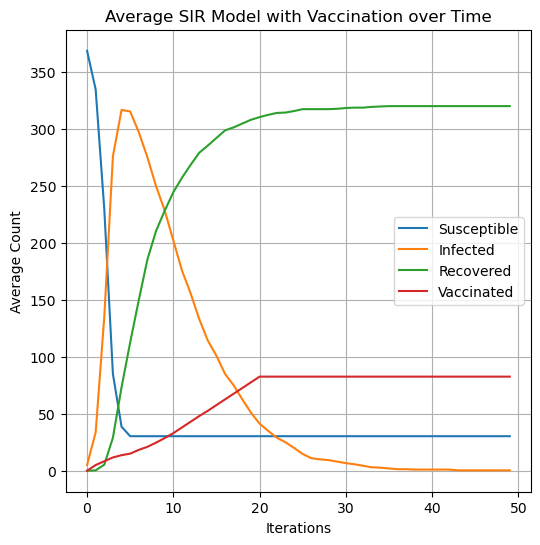

In [364]:
# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracy = 0.75
vaccination_budget_per_step = 5
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Step 1: Select initial infected nodes
initial_infected = select_initial_infected(G, num_initial_infected, seed=seed)

# Step 2: Run the SIR model with testing, vaccination, and multiple simulations
run_k_vaccination_200(
    G=G,
    beta=beta,
    gamma=gamma,
    initial_infected=initial_infected,
    num_iterations=num_iterations,
    max_tests_per_iteration=max_tests_per_iteration,
    test_accuracy=test_accuracy,
    vaccination_budget_per_step=vaccination_budget_per_step,
    seed=seed,
    num_simulations=num_simulations
)


#### Null strategy vaccination

In [297]:
# Step 1: Load the transmission network
df = pd.read_csv('transmission_network.csv', index_col=0, delimiter=';')
df = df.map(lambda x: 1 if x != 0 else x)
G = nx.from_numpy_array(df.values)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 374
Number of edges: 1265


In [323]:
# Step 2: Randomly select 5 initial infected nodes with a seed for reproducibility
def select_initial_infected(G, num_initial_infected, seed=None):
    """Randomly selects a number of nodes to be initially infected from the network G."""
    if seed is not None:
        random.seed(seed)
    initial_infected = random.sample(list(G.nodes), num_initial_infected)
    print(f"Selected {num_initial_infected} initial infected nodes: {initial_infected}")
    return initial_infected
initial_infected = select_initial_infected(G, 5, seed=42)


Selected 5 initial infected nodes: [327, 57, 12, 140, 125]


In [324]:
def dynamic_testing_null(G, model_status, test_accuracy, max_tests_per_iteration, vaccinated_nodes, positive_tested_nodes, time_step):
    """
    Dynamic testing strategy. Randomly select nodes for testing, up to the maximum number of tests allowed per iteration.
    """
    tested_positive = []
    tested_negative = []
    tested_this_round = set()  # Track tested nodes for the current iteration

    # Select eligible nodes for testing (those not vaccinated and not already tested positive)
    eligible_nodes = [n for n in G.nodes() if n not in vaccinated_nodes and n not in positive_tested_nodes]

    # If fewer eligible nodes than max tests, adjust the number of tests
    number_of_tests = min(max_tests_per_iteration, len(eligible_nodes))

    # Randomly sample nodes to test
    to_test = random.sample(eligible_nodes, number_of_tests)

    for node in to_test:
        if model_status[node] == 1:  # Node is infected
            if random.random() <= test_accuracy:
                tested_positive.append(node)
                positive_tested_nodes[node] = time_step
            else:
                tested_negative.append(node)
        else:  # Node is not infected
            tested_negative.append(node)

        tested_this_round.add(node)

    return tested_positive, tested_negative


In [356]:
# Dynamic vaccination function
def dynamic_vaccination_null(G, tested_negative, vaccinated_nodes, model_status, vaccination_budget):
    """
    Vaccinate nodes that have tested negative immediately, respecting the vaccination budget.
    """
    newly_vaccinated = []

    for node in tested_negative:
        if node not in vaccinated_nodes and vaccination_budget > 0:
            vaccinated_nodes.add(node)
            model_status[node] = 2  # Set to recovered
            newly_vaccinated.append(node)
            vaccination_budget -= 1

    return newly_vaccinated

In [381]:
def run_null_strategy_200(G, beta, gamma, initial_infected, num_iterations, max_tests_per_iteration, test_accuracy, vaccination_budget_per_step, seed=None, num_simulations=10, total_tests_limit=200):
    random.seed(seed)
    
    # Initialize accumulators for averages across simulations
    avg_s = [0] * num_iterations
    avg_i = [0] * num_iterations
    avg_r = [0] * num_iterations
    avg_vaccinated = [0] * num_iterations

    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")

        susceptible = set(G.nodes()) - set(initial_infected)
        infected = set(initial_infected)
        recovered = set()
        vaccinated_nodes = set()

        positive_tested_nodes = {}

        sim_s = []
        sim_i = []
        sim_r = []
        sim_vaccinated = []

        sim_s.append(len(susceptible))
        sim_i.append(len(infected))
        sim_r.append(len(recovered))
        sim_vaccinated.append(len(vaccinated_nodes))

        # Set the total number of tests remaining for the entire simulation
        total_tests_remaining = total_tests_limit

        for time_step in range(num_iterations):
            model_status = {node: 0 if node in susceptible else 1 if node in infected else 2 for node in G.nodes()}

            # Determine how many tests can be performed this iteration
            if total_tests_remaining > 0:
                tests_this_iteration = min(max_tests_per_iteration, total_tests_remaining)
            else:
                tests_this_iteration = 0

            # Test nodes only if there are tests remaining
            if tests_this_iteration > 0:
                test_positive, test_negative = dynamic_testing_null(
                    G, model_status, test_accuracy, tests_this_iteration, vaccinated_nodes, positive_tested_nodes, time_step
                )
            else:
                test_positive = []
                test_negative = []

            # Update the total number of tests remaining
            total_tests_remaining -= len(test_positive) + len(test_negative)

            # Vaccinate nodes based on the test results
            newly_vaccinated = dynamic_vaccination_null(G, test_negative, vaccinated_nodes, model_status, vaccination_budget_per_step)

            infected = infected - set(newly_vaccinated)

            # Spread infection
            new_infected = set()
            for node in infected:
                neighbors = set(G.neighbors(node)) - recovered - vaccinated_nodes
                for neighbor in neighbors:
                    if random.random() < beta:
                        new_infected.add(neighbor)

            # Recovery process
            new_recovered = set()
            for node in infected:
                if random.random() < gamma:
                    new_recovered.add(node)

            infected = (infected - new_recovered) | new_infected
            recovered = recovered | new_recovered

            susceptible = set(G.nodes()) - infected - recovered - vaccinated_nodes

            # Store the counts for this time step in the current simulation
            sim_s.append(len(susceptible))
            sim_i.append(len(infected))
            sim_r.append(len(recovered))
            sim_vaccinated.append(len(vaccinated_nodes))

            # Log only the tested positive/negative and vaccinated nodes for this iteration
            print(f"\nIteration {time_step + 1}:")
            print(f"Number of infected: {len(infected)}")
            print(f"Tested positive: {test_positive}")
            print(f"Tested negative: {test_negative}")
            print(f"Newly vaccinated: {newly_vaccinated}")
            print(f"Total tests remaining: {total_tests_remaining}")

            # Stop testing once all tests have been used
            if total_tests_remaining <= 0:
                print("No more tests remaining for this simulation.")
                # Continue running the simulation without further testing

        # Accumulate totals for averages
        avg_s = [x + y for x, y in zip(avg_s, sim_s)]
        avg_i = [x + y for x, y in zip(avg_i, sim_i)]
        avg_r = [x + y for x, y in zip(avg_r, sim_r)]
        avg_vaccinated = [x + y for x, y in zip(avg_vaccinated, sim_vaccinated)]

    # Compute averages
    avg_s = [x / num_simulations for x in avg_s]
    avg_i = [x / num_simulations for x in avg_i]
    avg_r = [x / num_simulations for x in avg_r]
    avg_vaccinated = [x / num_simulations for x in avg_vaccinated]

    # Plot the results
    # plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations)

    # After computing averages in the strategy functions, return the results:
    return avg_s, avg_i, avg_r, avg_vaccinated



In [358]:
# Plotting function
def plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations):
    count_row = 0
    count_col = 0

    fig, axes = plt.subplots(8, 3, figsize=(16, 12))

    axes[count_row, count_col].figure(figsize=(8, 6))
    axes[count_row, count_col].plot(avg_s, label='Susceptible', color='blue')
    axes[count_row, count_col].plot(avg_i, label='Infected', color='red')
    axes[count_row, count_col].plot(avg_r, label='Recovered', color='green')
    axes[count_row, count_col].plot(avg_vaccinated, label='Vaccinated', color='purple')
    axes[count_row, count_col].xlabel('Iterations')
    axes[count_row, count_col].ylabel('Average Count')
    axes[count_row, count_col].title('Average SIR Model with Vaccination over Time')
    axes[count_row, count_col].legend(loc='best')
    axes[count_row, count_col].grid(True)
    axes[count_row, count_col].show()

Selected 5 initial infected nodes: [327, 57, 12, 140, 125]
Simulation 1/3

Iteration 1:
Number of infected: 37
Tested positive: [327, 57, 12, 140, 125]
Tested negative: [114, 71, 52, 346, 279]
Newly vaccinated: [114]
Total tests remaining: 190

Iteration 2:
Number of infected: 180
Tested positive: []
Tested negative: [355, 337, 37, 316, 331, 89, 278, 129, 85, 241]
Newly vaccinated: [355]
Total tests remaining: 180

Iteration 3:
Number of infected: 329
Tested positive: [306, 156, 119, 93]
Tested negative: [273, 310, 149, 52, 101, 189]
Newly vaccinated: [273]
Total tests remaining: 170

Iteration 4:
Number of infected: 342
Tested positive: [188, 242, 326, 90, 356]
Tested negative: [208, 310, 60, 186, 373]
Newly vaccinated: [208]
Total tests remaining: 160

Iteration 5:
Number of infected: 332
Tested positive: [318, 281, 344, 20, 279, 56, 243]
Tested negative: [305, 287, 245]
Newly vaccinated: [305]
Total tests remaining: 150

Iteration 6:
Number of infected: 312
Tested positive: [76, 322

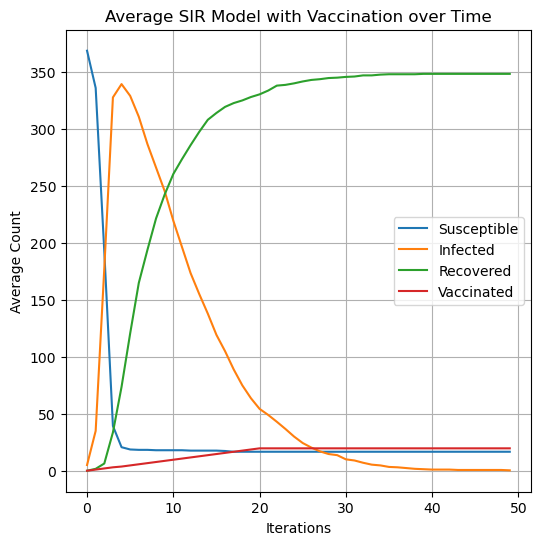

In [365]:
# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracy = 0.75
vaccination_budget_per_step = 1
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Step 1: Select initial infected nodes
initial_infected = select_initial_infected(G, num_initial_infected, seed=seed)

# Step 2: Run the SIR model with testing, vaccination, and multiple simulations
run_null_strategy_200(
    G=G,
    beta=beta,
    gamma=gamma,
    initial_infected=initial_infected,
    num_iterations=num_iterations,
    max_tests_per_iteration=max_tests_per_iteration,
    test_accuracy=test_accuracy,
    vaccination_budget_per_step=vaccination_budget_per_step,
    seed=seed,
    num_simulations=num_simulations
)


Simulation 1/3

Iteration 1:
Number of infected: 37
Tested positive: [327, 57, 12, 140, 125]
Tested negative: [114, 71, 52, 346, 279]
Newly vaccinated: [114, 71, 52]
Total tests remaining: 190

Iteration 2:
Number of infected: 176
Tested positive: [87]
Tested negative: [357, 339, 37, 318, 333, 91, 280, 131, 243]
Newly vaccinated: [357, 339, 37]
Total tests remaining: 180

Iteration 3:
Number of infected: 324
Tested positive: [365, 100, 104, 277]
Tested negative: [283, 117, 256, 150, 310, 314]
Newly vaccinated: [283, 117, 256]
Total tests remaining: 170

Iteration 4:
Number of infected: 335
Tested positive: [348, 216, 181, 232, 58, 5, 144, 123]
Tested negative: [364, 53]
Newly vaccinated: [364, 53]
Total tests remaining: 160

Iteration 5:
Number of infected: 325
Tested positive: [280, 49, 128, 241, 165, 220, 83, 190, 45]
Tested negative: [75]
Newly vaccinated: [75]
Total tests remaining: 150

Iteration 6:
Number of infected: 311
Tested positive: [213, 273, 159, 321, 342]
Tested negative

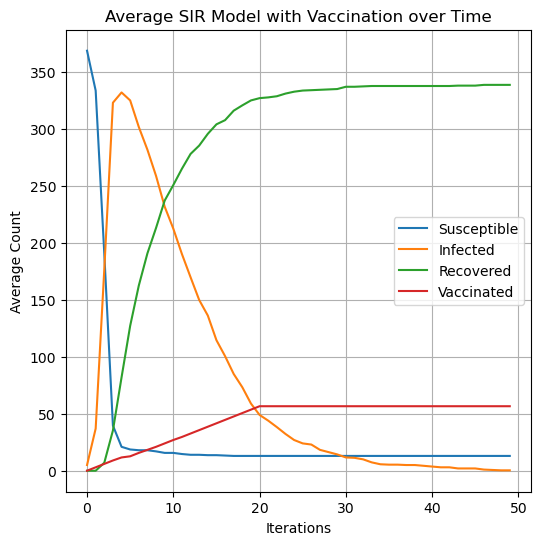

Simulation 1/3

Iteration 1:
Number of infected: 35
Tested positive: [12]
Tested negative: [20, 87, 76, 66, 277, 10, 71, 13, 67]
Newly vaccinated: [20, 87, 76]
Total tests remaining: 190

Iteration 2:
Number of infected: 159
Tested positive: [66, 10, 13, 8, 16]
Tested negative: [277, 71, 35, 289, 34]
Newly vaccinated: [277, 71, 35]
Total tests remaining: 180

Iteration 3:
Number of infected: 296
Tested positive: [178, 26, 34, 30, 29, 65]
Tested negative: [67, 105, 38, 83]
Newly vaccinated: [67, 105, 38]
Total tests remaining: 170

Iteration 4:
Number of infected: 320
Tested positive: [83, 289, 133, 313, 90, 262, 5, 221]
Tested negative: [12, 78]
Newly vaccinated: [12, 78]
Total tests remaining: 160

Iteration 5:
Number of infected: 312
Tested positive: [10, 13, 8, 9, 91, 93, 136]
Tested negative: [66, 16, 166]
Newly vaccinated: [66, 16, 166]
Total tests remaining: 150

Iteration 6:
Number of infected: 300
Tested positive: [26, 34, 29, 65, 186, 14, 51]
Tested negative: [178, 30, 79]
New

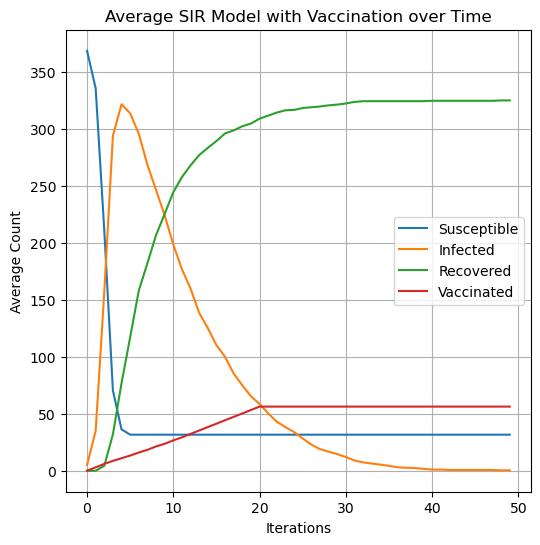

In [368]:
# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracy = [0.5, 0.75, 1]
vaccination_budget_per_step = [1, 3, 5, 10]
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

for budget in vaccination_budget_per_step:
    for accuracy in test_accuracy:


        run_null_strategy_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        run_k_vaccination_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
    )

In [382]:
def plot_sir_vaccine_results(ax, avg_s, avg_i, avg_r, avg_vaccinated):
    ax.plot(avg_s, label='Susceptible', color='blue')
    ax.plot(avg_i, label='Infected', color='red')
    ax.plot(avg_r, label='Recovered', color='green')
    ax.plot(avg_vaccinated, label='Vaccinated', color='purple')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Average Count')
    ax.grid(True)
    ax.legend(loc='best')


Simulation 1/3

Iteration 1:
Number of infected: 36
Tested positive: [327, 57, 12, 140]
Tested negative: [125, 114, 71, 52, 346, 279]
Newly vaccinated: [125]
Total tests remaining: 190

Iteration 2:
Number of infected: 179
Tested positive: []
Tested negative: [139, 364, 354, 336, 37, 315, 330, 89, 277, 128]
Newly vaccinated: [139]
Total tests remaining: 180

Iteration 3:
Number of infected: 330
Tested positive: [306, 156]
Tested negative: [112, 252, 146, 273, 310, 149, 52, 101]
Newly vaccinated: [112]
Total tests remaining: 170

Iteration 4:
Number of infected: 340
Tested positive: [17, 153]
Tested negative: [16, 115, 155, 146, 118, 282, 88, 241]
Newly vaccinated: [16]
Total tests remaining: 160

Iteration 5:
Number of infected: 333
Tested positive: [242, 49, 175, 67, 62]
Tested negative: [134, 366, 344, 87, 373]
Newly vaccinated: [134]
Total tests remaining: 150

Iteration 6:
Number of infected: 315
Tested positive: [283, 103, 355]
Tested negative: [308, 259, 273, 9, 68, 288, 99]
Newl

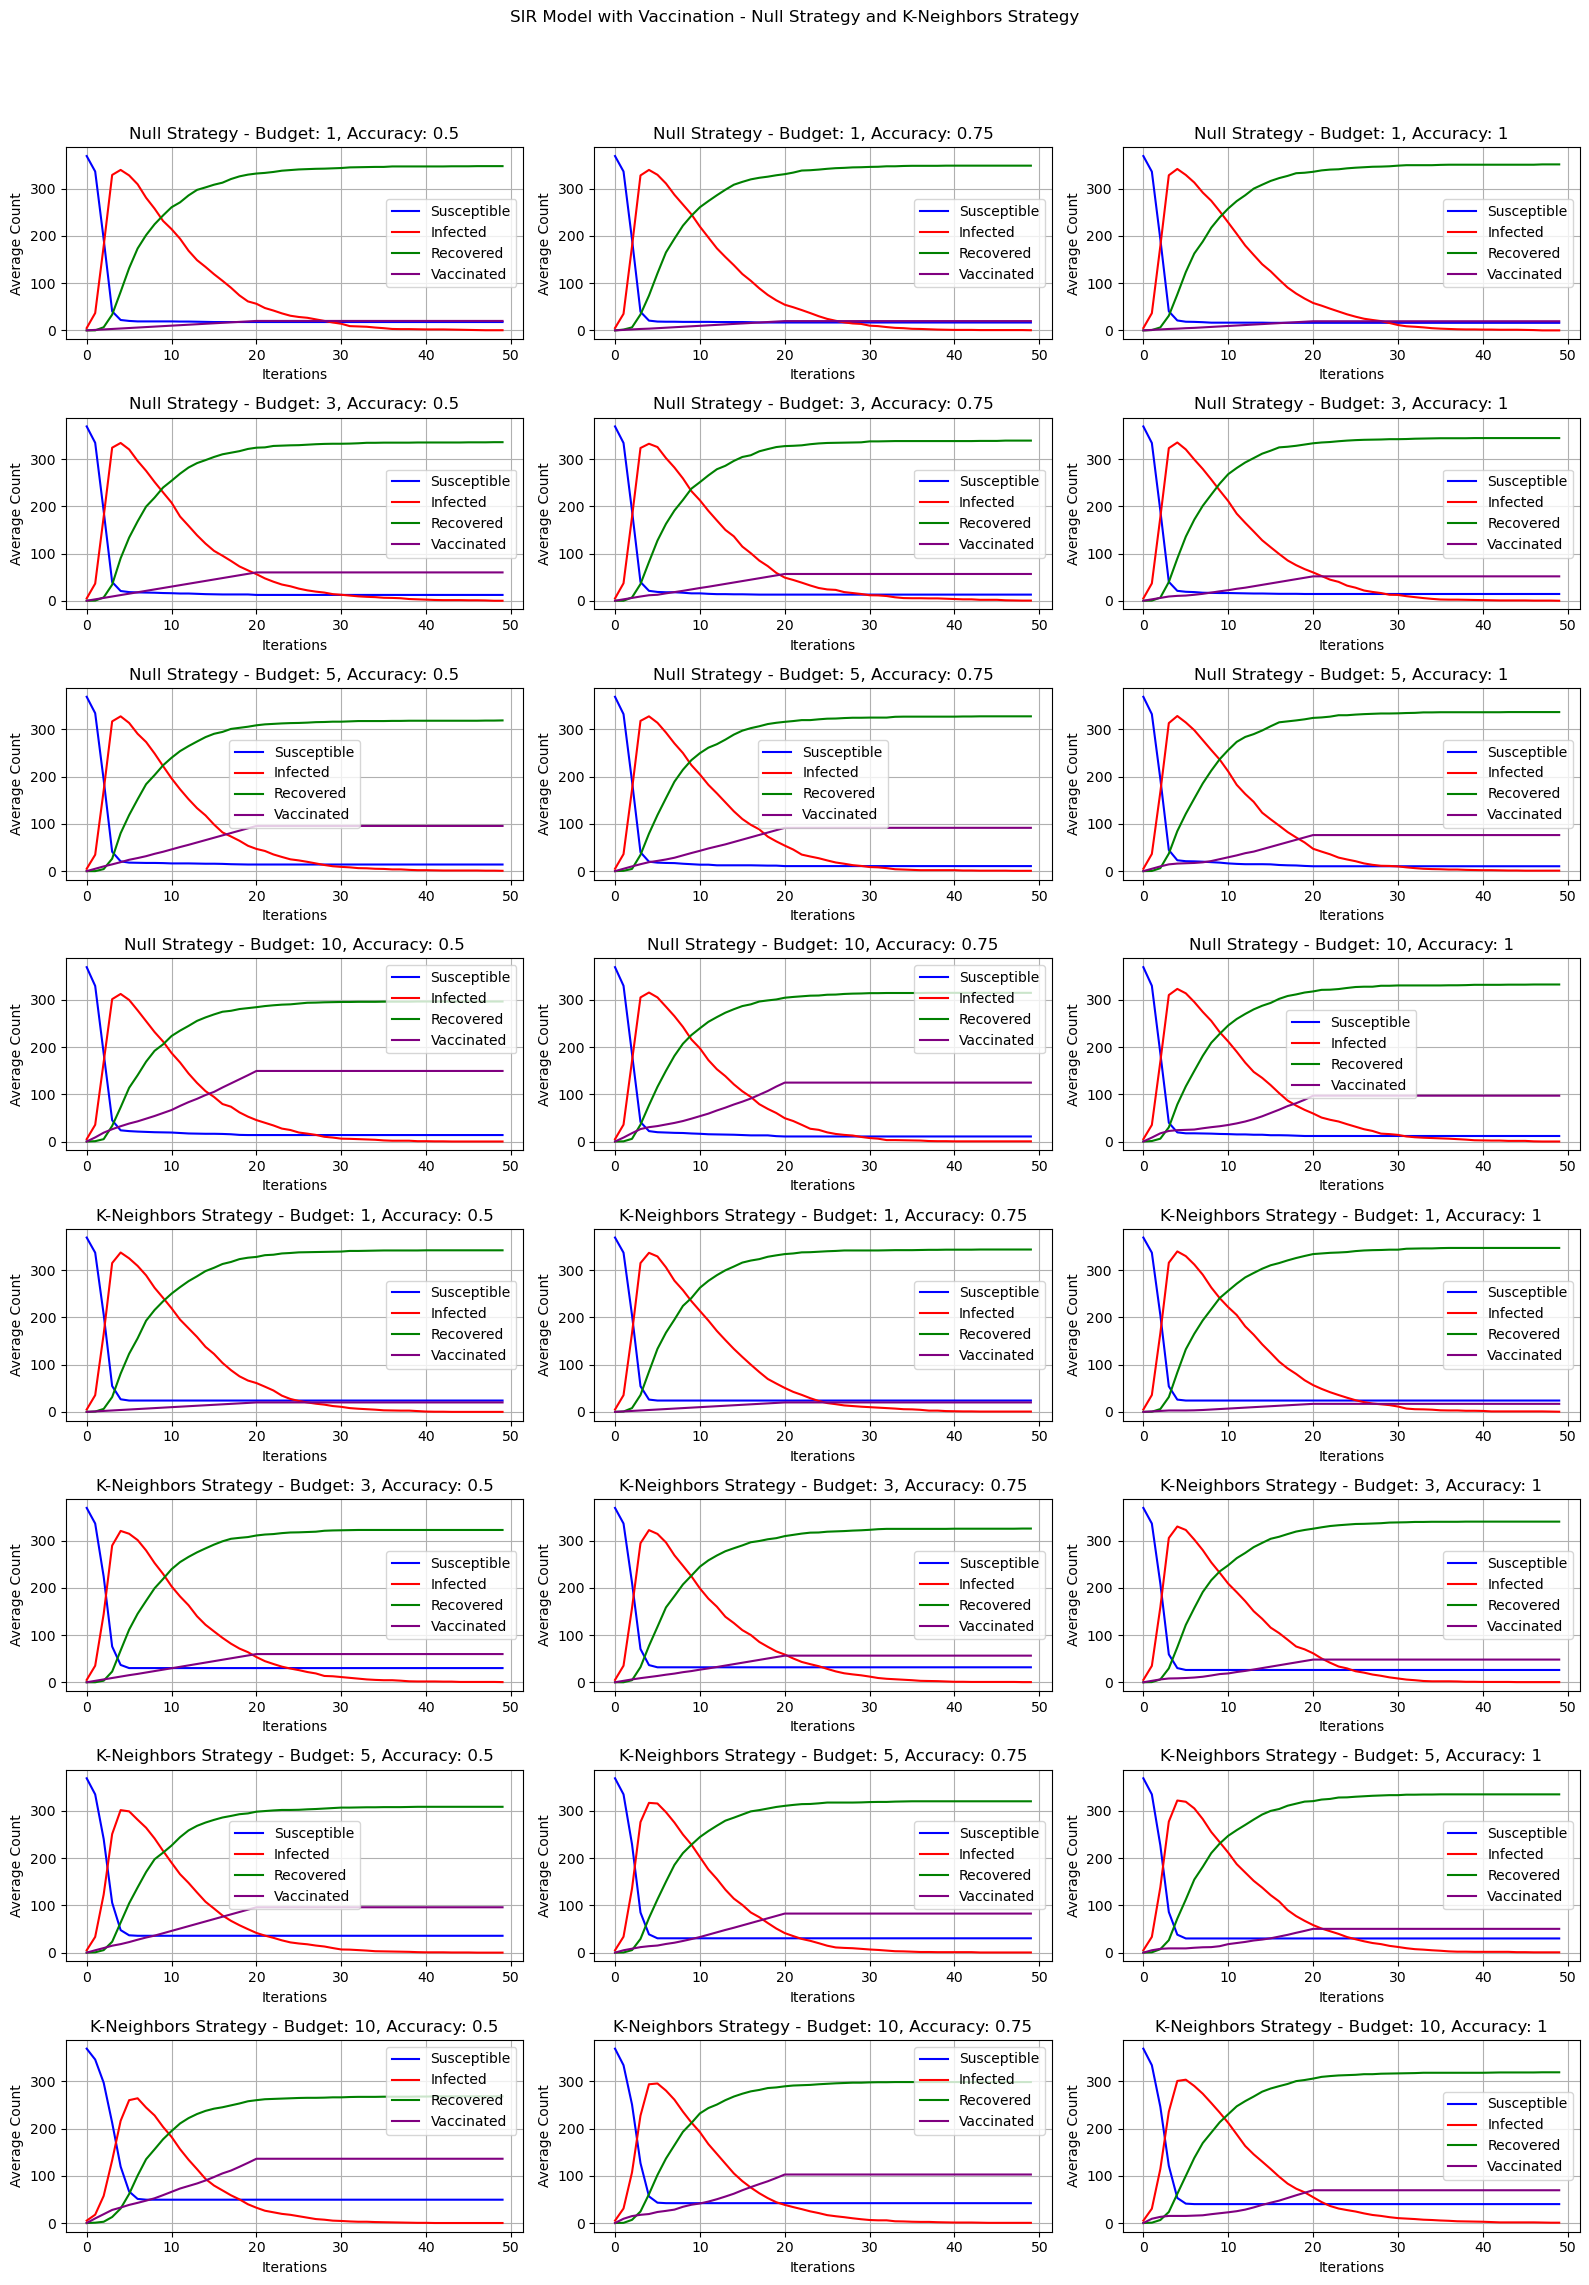

In [384]:


# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracies = [0.5, 0.75, 1]
vaccination_budgets = [1, 3, 5, 10]
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Prepare subplots (8 rows, 3 columns)
fig, axes = plt.subplots(8, 3, figsize=(16, 24))  # 8 rows (4 for each strategy) and 3 columns (for test accuracies)
fig.suptitle("SIR Model with Vaccination - Null Strategy and K-Neighbors Strategy")

# Ensure axes is always a 2D array (in case plt.subplots() returns a 1D array in some cases)
if axes.ndim == 1:
    axes = np.expand_dims(axes, axis=0)

# Loop through vaccination budgets and test accuracies
for i, budget in enumerate(vaccination_budgets):
    for j, accuracy in enumerate(test_accuracies):
        
        # Run the null strategy
        avg_s_null, avg_i_null, avg_r_null, avg_vaccinated_null = run_null_strategy_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot results for null strategy
        ax_null = axes[i, j]  # i is the row, j is the column
        plot_sir_vaccine_results(ax_null, avg_s_null, avg_i_null, avg_r_null, avg_vaccinated_null)
        ax_null.set_title(f'Null Strategy - Budget: {budget}, Accuracy: {accuracy}')
        
        # Run the k-neighbors strategy
        avg_s_k, avg_i_k, avg_r_k, avg_vaccinated_k = run_k_vaccination_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot results for k-neighbors strategy
        ax_k = axes[i + 4, j]  # i+4 shifts to the next 4 rows for the k-neighbors strategy
        plot_sir_vaccine_results(ax_k, avg_s_k, avg_i_k, avg_r_k, avg_vaccinated_k)
        ax_k.set_title(f'K-Neighbors Strategy - Budget: {budget}, Accuracy: {accuracy}')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leaves space for the main title
plt.show()


Simulation 1/3

Iteration 1:
Number of infected: 36
Tested positive: [327, 57, 12, 140]
Tested negative: [125, 114, 71, 52, 346, 279]
Newly vaccinated: [125]
Total tests remaining: 190

Iteration 2:
Number of infected: 179
Tested positive: []
Tested negative: [139, 364, 354, 336, 37, 315, 330, 89, 277, 128]
Newly vaccinated: [139]
Total tests remaining: 180

Iteration 3:
Number of infected: 330
Tested positive: [306, 156]
Tested negative: [112, 252, 146, 273, 310, 149, 52, 101]
Newly vaccinated: [112]
Total tests remaining: 170

Iteration 4:
Number of infected: 340
Tested positive: [17, 153]
Tested negative: [16, 115, 155, 146, 118, 282, 88, 241]
Newly vaccinated: [16]
Total tests remaining: 160

Iteration 5:
Number of infected: 333
Tested positive: [242, 49, 175, 67, 62]
Tested negative: [134, 366, 344, 87, 373]
Newly vaccinated: [134]
Total tests remaining: 150

Iteration 6:
Number of infected: 315
Tested positive: [283, 103, 355]
Tested negative: [308, 259, 273, 9, 68, 288, 99]
Newl

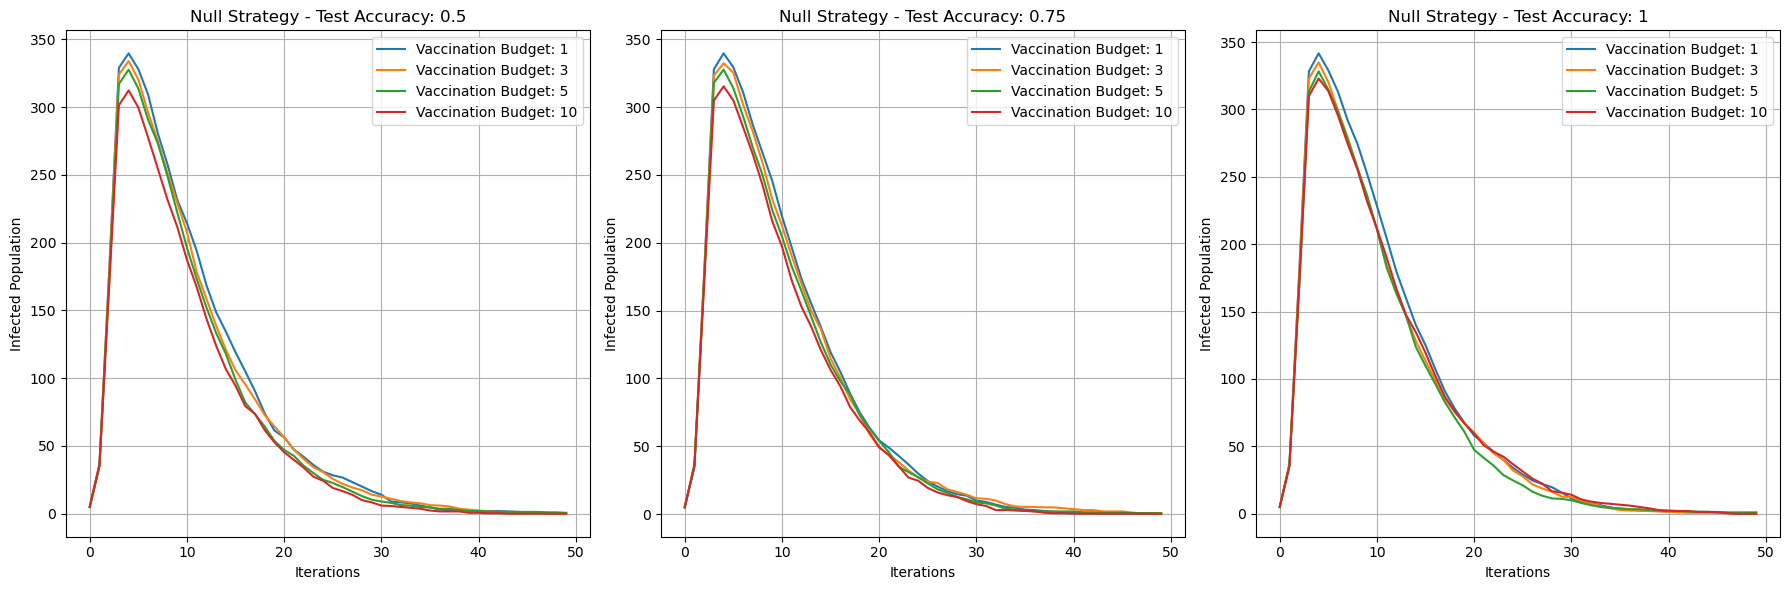

Simulation 1/3

Iteration 1:
Number of infected: 36
Tested positive: []
Tested negative: [20, 87, 76, 66, 277, 10, 71, 13, 67, 12]
Newly vaccinated: [20]
Total tests remaining: 190

Iteration 2:
Number of infected: 163
Tested positive: [66, 10, 13, 12, 8]
Tested negative: [87, 76, 277, 71, 35]
Newly vaccinated: [87]
Total tests remaining: 180

Iteration 3:
Number of infected: 315
Tested positive: [277, 71, 67, 105, 38, 178]
Tested negative: [76, 35, 83, 289]
Newly vaccinated: [76]
Total tests remaining: 170

Iteration 4:
Number of infected: 335
Tested positive: [16, 83, 26, 262]
Tested negative: [35, 289, 313, 9, 90, 5]
Newly vaccinated: [35]
Total tests remaining: 160

Iteration 5:
Number of infected: 322
Tested positive: [66, 13, 8, 289, 78, 133, 313]
Tested negative: [10, 12, 34]
Newly vaccinated: [10]
Total tests remaining: 150

Iteration 6:
Number of infected: 307
Tested positive: [67, 178, 9]
Tested negative: [277, 71, 105, 38, 12, 34, 90]
Newly vaccinated: [277]
Total tests rema

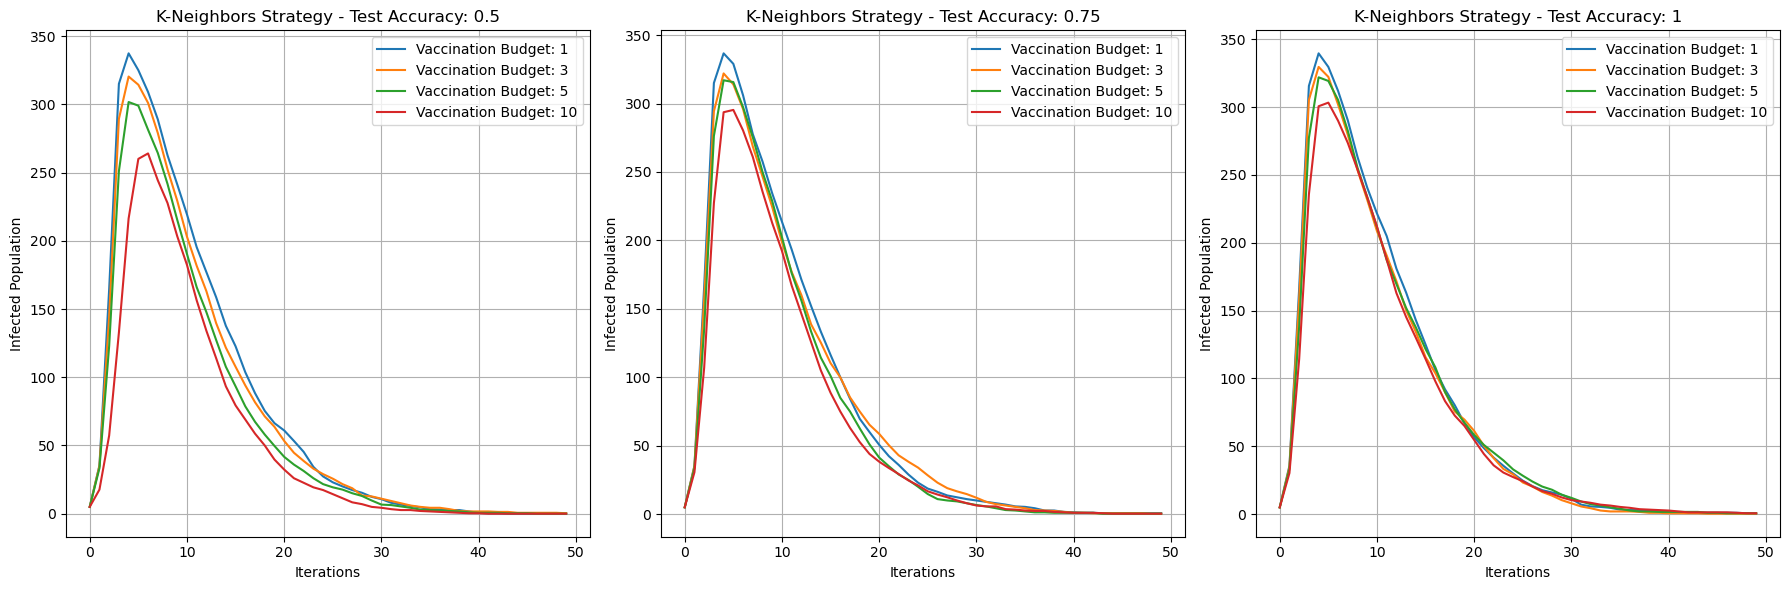

In [385]:


# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracies = [0.5, 0.75, 1]
vaccination_budgets = [1, 3, 5, 10]
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Plot for Null Strategy - Only Infected Population
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for j, accuracy in enumerate(test_accuracies):
    for budget in vaccination_budgets:
        # Run the null strategy
        avg_s_null, avg_i_null, avg_r_null, avg_vaccinated_null = run_null_strategy_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot only the infected population for each vaccination budget
        axes[j].plot(avg_i_null, label=f'Vaccination Budget: {budget}')

    axes[j].set_title(f'Null Strategy - Test Accuracy: {accuracy}')
    axes[j].set_xlabel('Iterations')
    axes[j].set_ylabel('Infected Population')
    axes[j].legend()
    axes[j].grid(True)

plt.tight_layout()
plt.show()

# Plot for K-Neighbors Strategy - Only Infected Population
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for j, accuracy in enumerate(test_accuracies):
    for budget in vaccination_budgets:
        # Run the k-neighbors strategy
        avg_s_k, avg_i_k, avg_r_k, avg_vaccinated_k = run_k_vaccination_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot only the infected population for each vaccination budget
        axes[j].plot(avg_i_k, label=f'Vaccination Budget: {budget}')

    axes[j].set_title(f'K-Neighbors Strategy - Test Accuracy: {accuracy}')
    axes[j].set_xlabel('Iterations')
    axes[j].set_ylabel('Infected Population')
    axes[j].legend()
    axes[j].grid(True)

plt.tight_layout()
plt.show()
